### note: implement auc metric 

### imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
import fastai; fastai.__version__

'1.0.55.dev0'

In [3]:
chexpert_path = Path("../../data/chexpert/")
mimic_path = Path("../../data/mimic-cxr")

In [4]:
chexpert_path.ls()

[PosixPath('../../data/chexpert/models'),
 PosixPath('../../data/chexpert/CheXpert-v1.0.zip'),
 PosixPath('../../data/chexpert/CheXpert-v1.0-small')]

In [5]:
mimic_path.ls()

[PosixPath('../../data/mimic-cxr/train'),
 PosixPath('../../data/mimic-cxr/chx_mimic_valid_320.csv'),
 PosixPath('../../data/mimic-cxr/chx_mimic_train_320.csv'),
 PosixPath('../../data/mimic-cxr/valid'),
 PosixPath('../../data/mimic-cxr/valid_320'),
 PosixPath('../../data/mimic-cxr/train.csv'),
 PosixPath('../../data/mimic-cxr/train_320'),
 PosixPath('../../data/mimic-cxr/valid.csv')]

In [6]:
torch.cuda.set_device(3)

### data

In [ ]:
chx_train_df = pd.read_csv(chexpert_path/"CheXpert-v1.0-small/train.csv")
chx_valid_df = pd.read_csv(chexpert_path/"CheXpert-v1.0-small/valid.csv")

In [ ]:
chx_train_df.head(2)

In [ ]:
mimic_train_df = pd.read_csv(mimic_path/"train.csv").rename(columns={"path":"Path", "Airspace Opacity": "Lung Opacity"})
mimic_valid_df = pd.read_csv(mimic_path/"valid.csv").rename(columns={"path":"Path", "Airspace Opacity": "Lung Opacity"})

In [ ]:
mimic_train_df.head(2)

In [ ]:
label_columns = list(chx_train_df.columns[5:])

In [ ]:
columns = ['Path'] + label_columns

In [ ]:
mimic_train_df['Path'] = mimic_train_df['Path'].apply(lambda x: 'mimic-cxr/'+x)
mimic_valid_df['Path'] = mimic_valid_df['Path'].apply(lambda x: 'mimic-cxr/'+x)
chx_train_df['Path'] = chx_train_df['Path'].apply(lambda x: 'chexpert/'+x)
chx_valid_df['Path'] = chx_valid_df['Path'].apply(lambda x: 'chexpert/'+x)

In [ ]:
# join chexpert and mimic train - valid
train_df = pd.concat([chx_train_df[columns], mimic_train_df[columns]])
valid_df = pd.concat([chx_valid_df[columns], mimic_valid_df[columns]])

In [ ]:
train_df.shape, valid_df.shape

In [ ]:
# https://github.com/stanfordmlgroup/chexpert-labeler/issues/9
train_df[label_columns] = train_df[label_columns].fillna(-1)

In [ ]:
{c: train_df[c].unique() for c in label_columns}

In [ ]:
{c: valid_df[c].unique() for c in label_columns}

In [ ]:
train_df.head()

### U-ignore

In [ ]:
train_df[label_columns].apply(lambda x: (x == -1).sum()/len(x))

In [ ]:
train_df[label_columns].apply(lambda x: (x != -1).sum())

In [ ]:
train_df.head()

In [ ]:
train_df.tail()

### training size

In [ ]:
sz = 320

In [ ]:
train_df.Path = train_df.Path.apply(lambda x: x.replace("train", f"train_{sz}"))
valid_df.Path = valid_df.Path.apply(lambda x: x.replace("train", f"valid_{sz}"))

In [ ]:
# shape of Chexpert small
data_path = Path("../../data")

In [ ]:
open_image(data_path/train_df.Path.values[4]).data.shape

In [ ]:
# shape of MIMIC CXR
open_image(data_path/train_df.Path.values[-1]).data.shape

In [ ]:
train_df.shape, valid_df.shape

In [ ]:
train_df = train_df.fillna(-1); 
valid_df = valid_df.fillna(-1)

In [ ]:
train_df.to_csv(mimic_path/"chx_mimic_train_320.csv", index=False)
valid_df.to_csv(mimic_path/"chx_mimic_valid_320.csv", index=False)

### databunch 

In [7]:
train_df = pd.read_csv(mimic_path/"chx_mimic_train_320.csv")
valid_df = pd.read_csv(mimic_path/"chx_mimic_valid_320.csv")

In [8]:
label_columns = train_df.columns[1:]

In [9]:
label_columns

Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices'],
      dtype='object')

In [10]:
sz,bs=320,64
data_path = Path("../../data")

In [11]:
train_valid_df = pd.concat([train_df, valid_df])

In [12]:
il = ImageList.from_df(train_valid_df, data_path, cols=['Path'])

In [13]:
ill = il.split_by_rand_pct(valid_pct=0.02, seed=42)

In [14]:
assert train_valid_df.shape[0] == (len(ill.train) + len(ill.valid))

In [15]:
train_fnames = ["/".join(s.split("/")[4:]) for s in ill.train.items]
valid_fnames = ["/".join(s.split("/")[4:]) for s in ill.valid.items]

In [16]:
assert train_valid_df.shape[0] == (len(train_fnames) + len(valid_fnames))

In [17]:
# create labels
is_train = train_valid_df.Path.apply(lambda x: '/'.join(x.split('/')[1:])).isin(train_fnames)
train_labels = np.array(train_valid_df.loc[is_train, label_columns])
valid_labels = np.array(train_valid_df.loc[~is_train, label_columns])

In [18]:
assert train_valid_df.shape[0] == (len(train_labels) + len(valid_labels))

In [19]:
tfms = get_transforms()
pretrained = True

data = (ill.label_from_lists(list(train_labels), list(valid_labels), label_cls=FloatList)
        .transform(tfms, size=sz)
        .databunch(bs=bs))
data = data.normalize(imagenet_stats) if pretrained else data.normalize()

In [20]:
assert train_valid_df.shape[0] == (len(data.train_ds) + len(data.valid_ds))

In [21]:
# set data classes
data.classes = label_columns
data.classes, data.stats

(Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
        'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
        'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
        'Fracture', 'Support Devices'],
       dtype='object'), ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))

In [22]:
# data.show_batch(3)

### model

In [23]:
from chexpert_dev.uignore import *

In [24]:
pretrained = True
# eps = 1e-4
# opt_func= partial(optim.Adam, betas=(0.9,0.99), eps=eps)

In [29]:
if pretrained:
    learn = cnn_learner(data, models.densenet121, pretrained=True,
                        loss_func=MaskedBCEWithLogitsLoss()).to_fp16()
else:                                  
    learn = Learner(data, models.xresnet34(c_out=data.c),
                    loss_func=MaskedBCEWithLogitsLoss()).to_fp16()

In [30]:
roc_auc_cb = MaskedMultiLabelROCAUC(learn=learn, verbose=False)

In [32]:
learn.metrics = [partial(masked_accuracy_thres, thres=0.5, m=-1)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


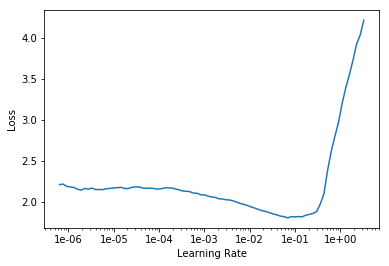

In [33]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# training from scratch
learn.fit_one_cycle(5, 1e-2, callbacks=[roc_auc_cb])

epoch,train_loss,valid_loss,masked_accuracy_thres,mean_roc_auc,time
0,0.816102,1.841371,0.738442,0.767697,1:21:20


In [ ]:
# # transfer learning

lr=1e-2
# learn.fit_one_cycle(5, lr)

learn.freeze_to(-1)

learn.fit_one_cycle(5, slice(lr/5))

learn.unfreeze()

learn.fit_one_cycle(5, slice(lr/10))

In [ ]:
# learn.save(f"u-ignore-resnet34-{sz}")
# learn.to_fp32().save(f"u-ignore-resnext34-{sz}")
learn.to_fp32().save(f"chx-mimic-u-ignore-densenet121-{sz}")

In [41]:
learn.load(f"chx-mimic-u-ignore-densenet121-{sz}");

In [42]:
learn.validate(callbacks=[roc_auc_cb])

[1.7854761, tensor(0.7342), tensor(0.5044)]

### add test

In [41]:
test = ImageList.from_df(valid_df, data_path, cols=['Path'])

In [42]:
learn.data.add_test(test)

In [43]:
# learn.load(f"u-ignore-resnext34-{sz}");
learn.load(f"u-ignore-densenet121-{sz}");

/home/turgutluk/.conda/envs/my_fastai/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MaskedBCEWithLogitsLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### per class AUCs of test

In [52]:
preds, targs = learn.get_preds(DatasetType.Test)

In [53]:
probas = preds.sigmoid()

In [54]:
targs = tensor(np.array(valid_df[label_columns]))

In [55]:
targs.shape, probas.shape

(torch.Size([234, 14]), torch.Size([234, 14]))

In [56]:
from sklearn.metrics import roc_auc_score, auc

In [86]:
{c:roc_auc_score(targs[:,i], probas[:, i]) for i,c in enumerate(label_columns[:-2])}

{'No Finding': 0.5222878625134264,
 'Enlarged Cardiomediastinum': 0.864,
 'Cardiomegaly': 0.8412473423104182,
 'Lung Opacity': 0.8974132863021752,
 'Lung Lesion': 0.5708154506437768,
 'Edema': 0.8883009994121105,
 'Consolidation': 0.9219056233981606,
 'Pneumonia': 0.7466814159292036,
 'Atelectasis': 0.8350649350649352,
 'Pneumothorax': 0.6786504424778761,
 'Pleural Effusion': 0.9098221467512735,
 'Pleural Other': 0.4377682403433476}

In [292]:
{c:roc_auc_score(targs[:,i], probas[:, i]) for i,c in enumerate(label_columns[:-2])}

{'No Finding': 0.5781417830290011,
 'Enlarged Cardiomediastinum': 0.8956330275229358,
 'Cardiomegaly': 0.8657866761162296,
 'Lung Opacity': 0.8851410934744269,
 'Lung Lesion': 0.7896995708154506,
 'Edema': 0.8754850088183421,
 'Consolidation': 0.9139152721242273,
 'Pneumonia': 0.8213495575221239,
 'Atelectasis': 0.8271915584415584,
 'Pneumothorax': 0.7809734513274336,
 'Pleural Effusion': 0.9257306282956475,
 'Pleural Other': 0.40343347639484983}

In [58]:
np.mean([roc_auc_score(targs[:,i], probas[:, i]) for i,c in enumerate(label_columns[:-2])])

0.7594964787622253